<div style="text-align: left;">
  <font color='Brown2'>
    <strong>
      <span style="font-size: 15px; ">
        KHÓA LUẬN TỐT NGHIỆP
      </span>
    </strong>
  </font>
</div>
<div style="text-align: left;">
  <font color='Brown4'>
    <strong>
      <span style="font-size: 15px;">
        HỌ VÀ TÊN SINH VIÊN: NGUYỄN LƯƠNG ĐÌNH NGUYỄN  
      </span>
    </strong>
  </font>
</div>
<div style="text-align: left;">
  <font color='Brown4'>
    <strong>
      <span style="font-size: 15px;">
        GVHD: TRIỆU KIM LANH
      </span>
    </strong>
  </font>
</div>

# THƯ VIỆN

- **CHUẨN BỊ (CÀI ĐẶT THƯ VIỆN)**

In [1]:
!pip install matplotlib pandas ta gymnasium shimmy>=2.2.0 stable-baselines3[extra] optuna scikit-learn

In [2]:
# THƯ VIỆN CHUẨN CỦA PYTHON
import os
import logging
import argparse
from dataclasses import dataclass
from typing import Any, Dict, List, Optional
import warnings
from datetime import timedelta
# THƯ VIỆN XỬ LÝ MÔI TRƯỜNG VÀ RL
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import (
    CheckpointCallback,
    EvalCallback,
    StopTrainingOnRewardThreshold
)
from stable_baselines3.common.vec_env import (
    DummyVecEnv,
    VecNormalize,
    VecMonitor
)
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CallbackList
# THƯ VIỆN HỌC MÁY & XỬ LÝ DỮ LIỆU
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.covariance import LedoitWolf
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix)
# TỐI ƯU HÓA VÀ TÌM SIÊU THAM SỐ
from scipy.optimize import minimize
import optuna
# THƯ VIỆN TRỰC QUAN HÓA
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from tqdm import tqdm

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


# **BƯỚC 1:** THU THẬP DỮ LIỆU

In [3]:
# 1. Tải file từ máy bạn
from google.colab import files
import io # Import the io module
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['vn30_30stocks_train_2021_2023_con10cp.csv']))
# In ra một số dòng đầu tiên của DataFrame
print(df.head())
print(df.info())

Saving vn30_30stocks_test_2024.csv to vn30_30stocks_test_2024.csv
Saving vn30_30stocks_test_2024_con10cp.csv to vn30_30stocks_test_2024_con10cp.csv
Saving vn30_30stocks_train_2021_2023.csv to vn30_30stocks_train_2021_2023.csv
Saving vn30_30stocks_train_2021_2023_con10cp.csv to vn30_30stocks_train_2021_2023_con10cp.csv
       date   id   open   high    low  close    volume   sector source
0  1/4/2021  ACB  10.71  10.82  10.69  10.75  10776300  Banking   TCBS
1  1/5/2021  ACB  10.73  11.11  10.62  11.01  18693900  Banking   TCBS
2  1/6/2021  ACB  11.14  11.48  10.99  11.22  15883900  Banking   TCBS
3  1/7/2021  ACB  11.24  11.26  11.11  11.22  11636100  Banking   TCBS
4  1/8/2021  ACB  11.24  11.41  11.18  11.33  15519300  Banking   TCBS
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7448 entries, 0 to 7447
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    7448 non-null   object 
 1   id      7448 non-null   object 


- **XỬ LÝ DỮ LIỆU** (DATA OHLCV)

In [4]:
# Xem có bao nhiêu cổ phiếu
print("Số cổ phiếu:", df['id'].nunique())
print("Mã cổ phiếu:", df['id'].unique())
# Xem dải ngày
print("Từ ngày:", df['date'].min(), "đến ngày:", df['date'].max())
# Kiểm tra số ngày giao dịch cho từng cổ phiếu
stock_counts = df.groupby('id')['date'].nunique().sort_values()
print(stock_counts.tail())

Số cổ phiếu: 10
Mã cổ phiếu: ['ACB' 'BCM' 'FPT' 'GAS' 'HDB' 'MBB' 'SSB' 'VCB' 'VIB' 'VPB']
Từ ngày: 1/10/2022 đến ngày: 9/9/2022
id
HDB    748
MBB    748
VCB    748
VIB    748
VPB    748
Name: date, dtype: int64


In [5]:
min_days = 250  # hoặc = window_size + 1
valid_tickers = stock_counts[stock_counts >= min_days].index.tolist()
df = df[df['id'].isin(valid_tickers)].copy()

# **BƯỚC 2:** TÍNH TOÁN CÁC CHỈ SỐ KỸ THUẬT

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
# === Các hàm chỉ báo kỹ thuật ===
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))
def compute_bollinger_bands(series, window=20, num_std=2):
    ma = series.rolling(window=window).mean()
    std = series.rolling(window=window).std()
    upper = ma + num_std * std
    lower = ma - num_std * std
    return upper, lower
def compute_atr(high, low, close, period=14):
    tr = pd.concat([
        high - low,
        abs(high - close.shift(1)),
        abs(low - close.shift(1))
    ], axis=1).max(axis=1)
    return tr.rolling(window=period).mean()
def compute_obv(close, volume):
    obv = [0]
    for i in range(1, len(close)):
        if close.iloc[i] > close.iloc[i - 1]:
            obv.append(obv[-1] + volume.iloc[i])
        elif close.iloc[i] < close.iloc[i - 1]:
            obv.append(obv[-1] - volume.iloc[i])
        else:
            obv.append(obv[-1])
    return pd.Series(obv, index=close.index)
def compute_volume_oscillator(volume, short=5, long=20):
    short_ma = volume.rolling(window=short).mean()
    long_ma = volume.rolling(window=long).mean()
    return ((short_ma - long_ma) / long_ma) * 100
def compute_macd(series, short=12, long=26, signal=9):
    ema_short = series.ewm(span=short, adjust=False).mean()
    ema_long = series.ewm(span=long, adjust=False).mean()
    macd = ema_short - ema_long
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    hist = macd - signal_line
    return macd, signal_line, hist
# === Tính các chỉ báo kỹ thuật cho từng cổ phiếu ===
def add_indicators_per_stock(df):
    df = df.copy().sort_values(['id', 'date'])
    result = []
    for stock_id in df['id'].unique():
        stock = df[df['id'] == stock_id].copy()
        stock['sma_5'] = stock['close'].rolling(5).mean()
        stock['sma_20'] = stock['close'].rolling(20).mean()
        stock['ema_10'] = stock['close'].ewm(span=10, adjust=False).mean()
        stock['rsi_14'] = compute_rsi(stock['close'], 14)
        stock['momentum'] = stock['close'] - stock['close'].shift(5)
        stock['bb_upper'], stock['bb_lower'] = compute_bollinger_bands(stock['close'])
        stock['atr_14'] = compute_atr(stock['high'], stock['low'], stock['close'], 14)
        stock['obv'] = compute_obv(stock['close'], stock['volume'])
        stock['vol_osc'] = compute_volume_oscillator(stock['volume'])
        stock['macd'], stock['macd_signal'], stock['macd_hist'] = compute_macd(stock['close'])
        result.append(stock)
    return pd.concat(result).reset_index(drop=True)

In [7]:
add_indicators_per_stock(df)

,date,id,open,high,low,close,volume,sector,source,sma_5,...,rsi_14,momentum,bb_upper,bb_lower,atr_14,obv,vol_osc,macd,macd_signal,macd_hist
0,1/10/2022,ACB,15.48,15.66,15.45,15.48,5693200,Banking,TCBS,NaN,...,NaN,NaN,NaN,NaN,NaN,0,NaN,0.000000,0.000000,0.000000
1,1/10/2023,ACB,13.63,13.75,13.45,13.75,3062873,Banking,TCBS,NaN,...,NaN,NaN,NaN,NaN,NaN,-3062873,NaN,-0.138006,-0.027601,-0.110405
2,1/11/2021,ACB,11.44,11.59,11.31,11.39,9821800,Banking,TCBS,NaN,...,NaN,NaN,NaN,NaN,NaN,-12884673,NaN,-0.432819,-0.108645,-0.324174
3,1/11/2022,ACB,15.48,15.50,15.34,15.36,6395100,Banking,TCBS,NaN,...,NaN,NaN,NaN,NaN,NaN,-6489573,NaN,-0.342171,-0.155350,-0.186821
4,1/11/2023,ACB,13.84,14.33,13.75,14.19,5342324,Banking,TCBS,14.034,...,NaN,NaN,NaN,NaN,NaN,-11831897,NaN,-0.360584,-0.196397,-0.164187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7443,9/8/2021,VPB,20.76,20.79,20.24,20.24,5217900,Banking,TCBS,19.426,...,52.359347,1.80,22.881896,15.072104,2.582143,1965943326,35.985948,0.091448,-0.041186,0.132634
7444,9/8/2022,VPB,17.83,17.92,17.56,17.56,10654300,Banking,TCBS,19.096,...,43.947689,-1.65,22.464661,15.058339,2.555000,1955289026,13.481187,-0.041815,-0.041312,-0.000503
7445,9/8/2023,VPB,19.16,19.30,19.12,19.21,16769386,Banking,TCBS,18.794,...,55.805893,-1.51,22.404500,15.429500,2.273571,1972058412,22.287383,-0.014123,-0.035874,0.021751
7446,9/9/2021,VPB,20.24,20.72,20.24,20.69,6166500,Banking,TCBS,19.372,...,52.899889,2.89,22.595444,15.457556,2.148571,1978224912,3.995661,0.125796,-0.003540,0.129337


In [8]:
# Tính toán chỉ báo cho từng cổ phiếu và cho chỉ số VN30
df = df.sort_values(["id", "date"]).reset_index(drop=True)
# Sử dụng ffill + bfill chuẩn, không warning
df = df.groupby("id", group_keys=False).apply(lambda x: x.ffill().bfill())
# Bỏ NaN còn sót lại
df = df.dropna()
# Kiểm tra lại
print("Số giá trị NaN còn lại:", df.isna().sum().sum())

Số giá trị NaN còn lại: 0


/tmp/ipython-input-2401154798.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("id", group_keys=False).apply(lambda x: x.ffill().bfill())


/tmp/ipython-input-3893303228.py:95: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("id", group_keys=False).apply(lambda x: x.ffill().bfill()).dropna()


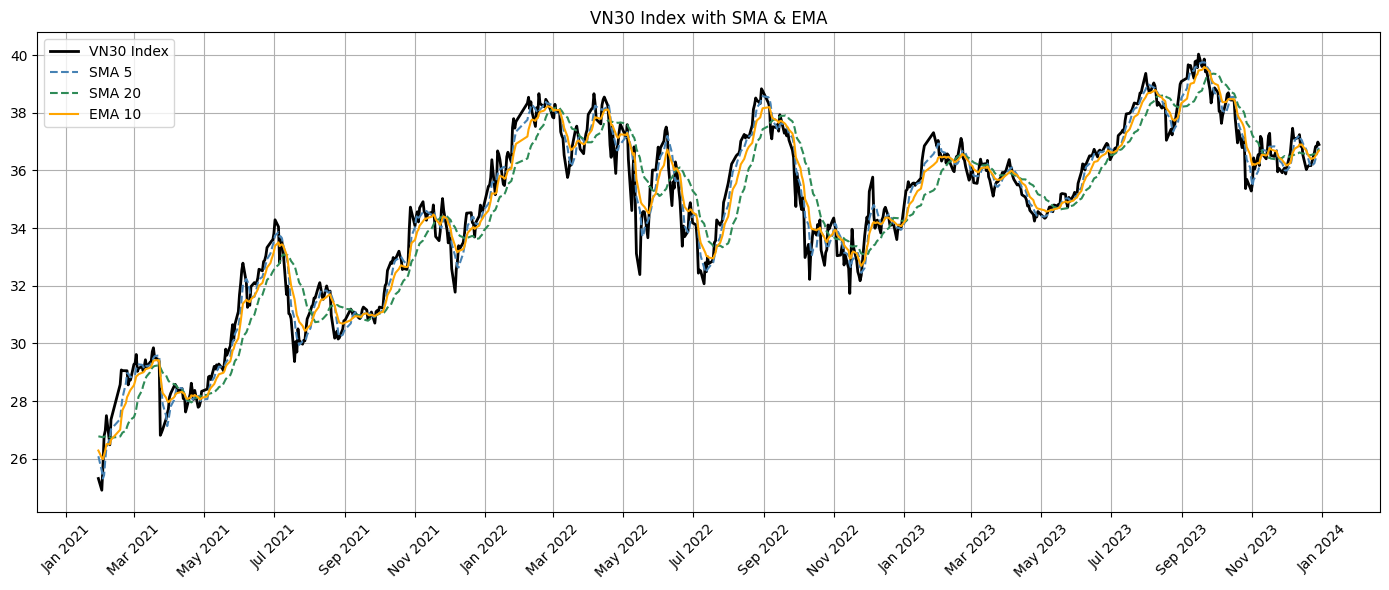

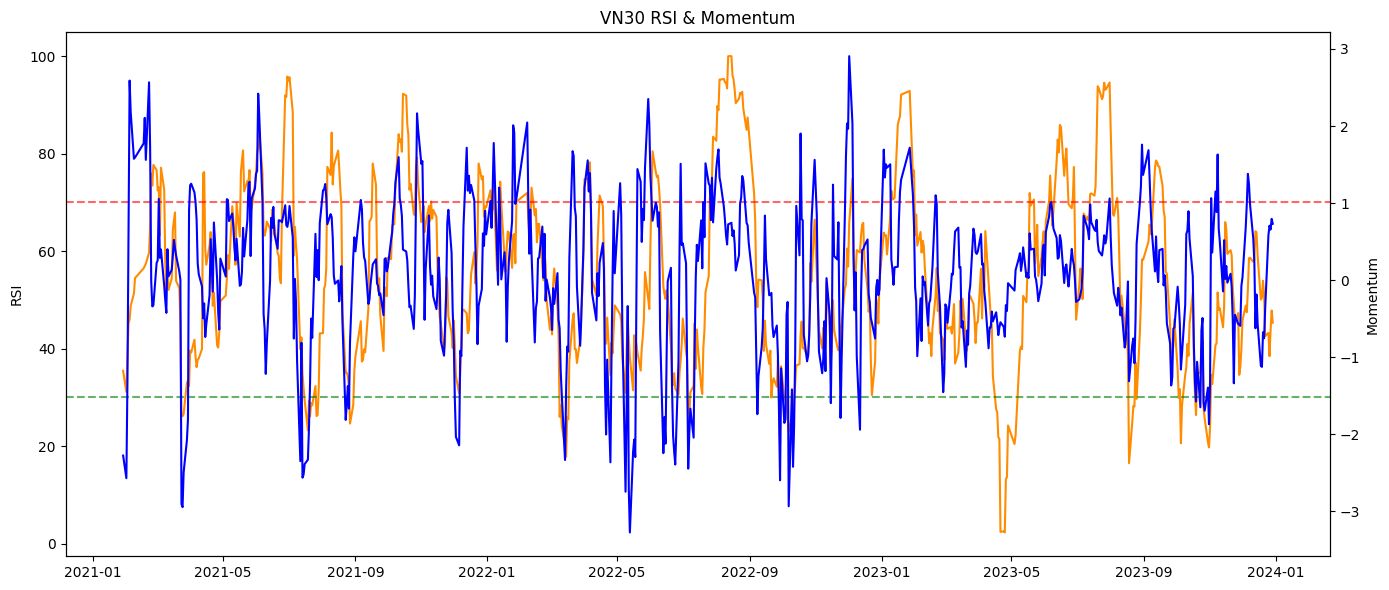

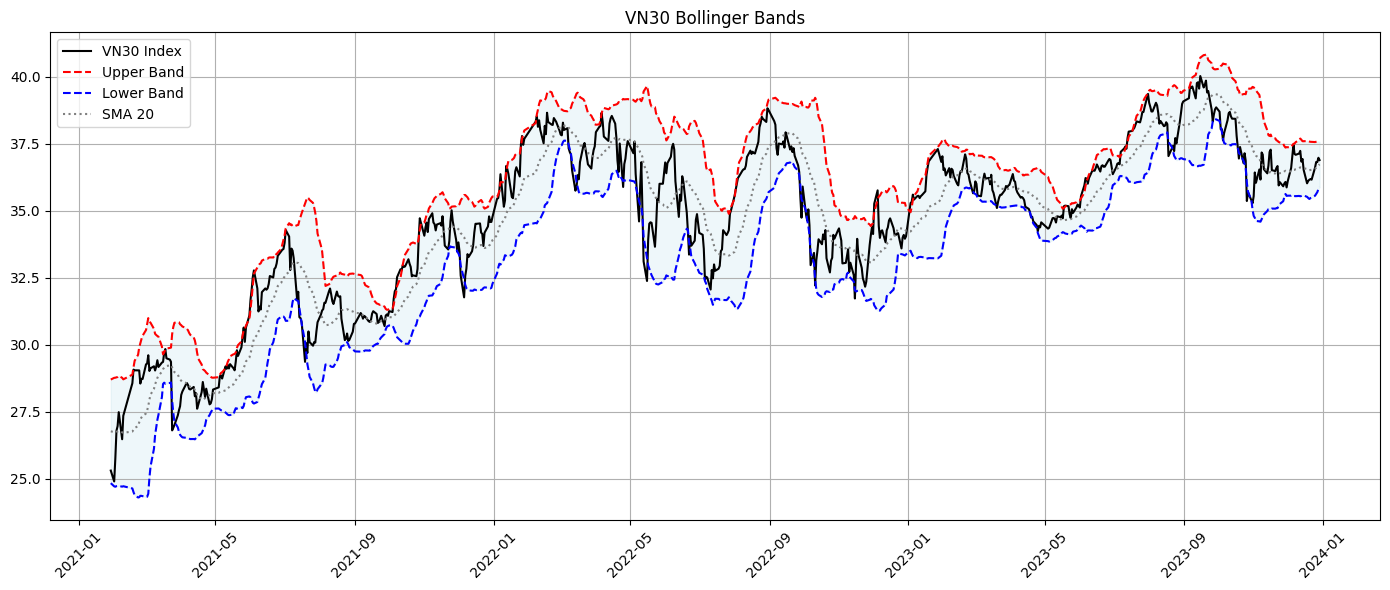

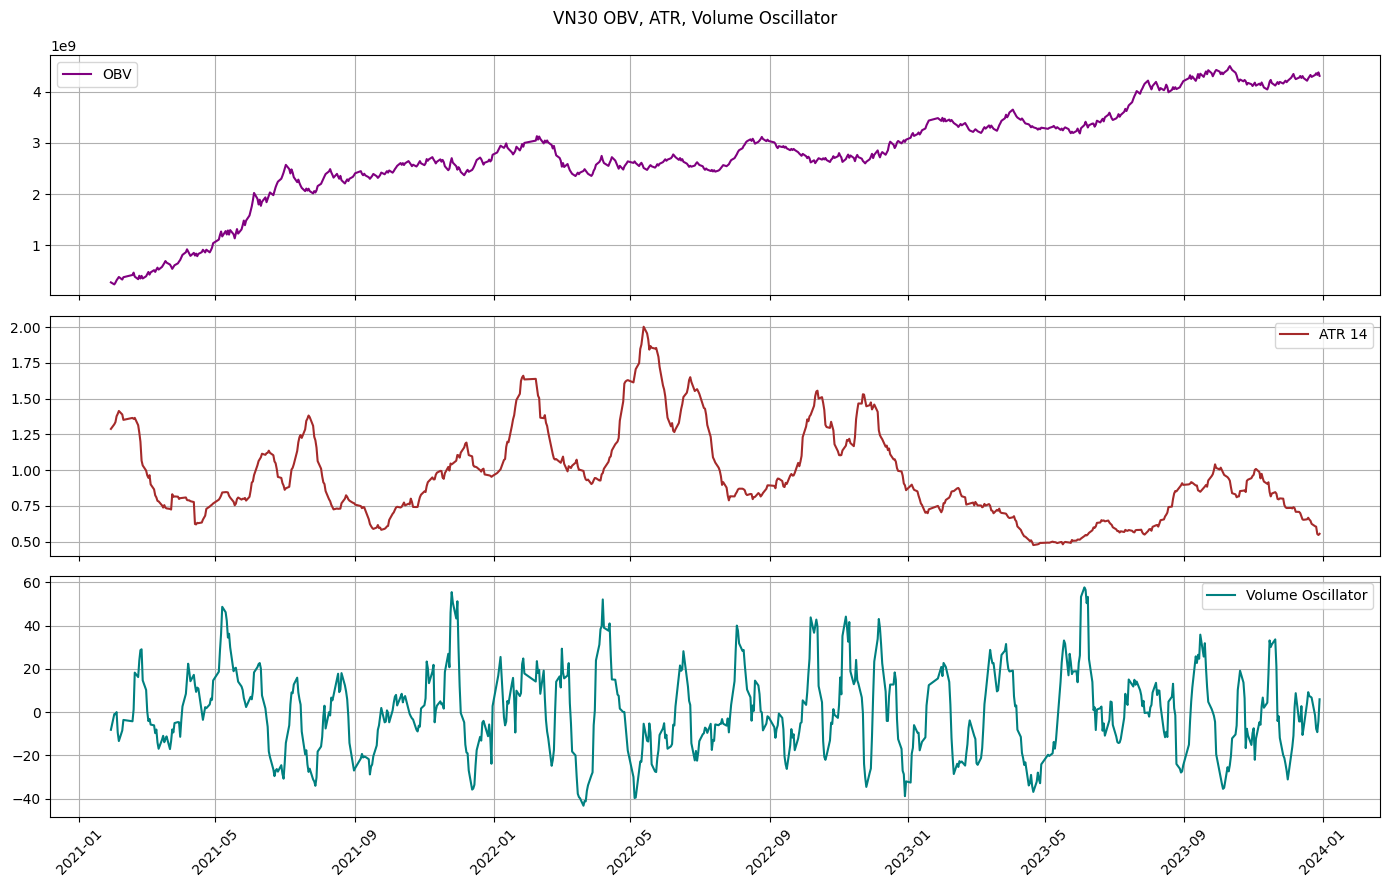

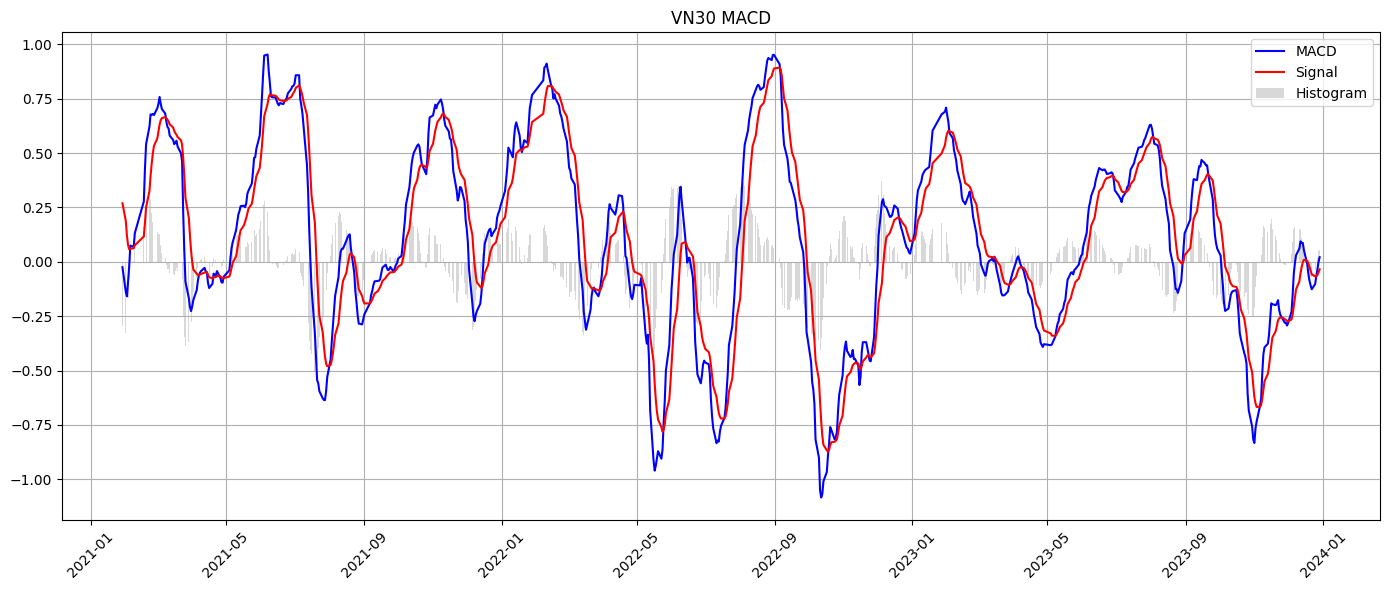

In [9]:
# === Tính chỉ số VN30 và chỉ báo của nó ===
def compute_vn30_index_with_indicators(df):
    df = df.copy()
    df = add_indicators_per_stock(df)
    daily_df = df.groupby('date').agg({
        'high': 'mean',
        'low': 'mean',
        'close': 'mean',
        'volume': 'sum'
    }).reset_index()
    daily_df.rename(columns={'close': 'vn30_index'}, inplace=True)
    daily_df['sma_5'] = daily_df['vn30_index'].rolling(5).mean()
    daily_df['sma_20'] = daily_df['vn30_index'].rolling(20).mean()
    daily_df['ema_10'] = daily_df['vn30_index'].ewm(span=10, adjust=False).mean()
    daily_df['rsi_14'] = compute_rsi(daily_df['vn30_index'], 14)
    daily_df['momentum'] = daily_df['vn30_index'] - daily_df['vn30_index'].shift(5)
    daily_df['bb_upper'], daily_df['bb_lower'] = compute_bollinger_bands(daily_df['vn30_index'])
    daily_df['atr_14'] = compute_atr(daily_df['high'], daily_df['low'], daily_df['vn30_index'], 14)
    daily_df['obv'] = compute_obv(daily_df['vn30_index'], daily_df['volume'])
    daily_df['vol_osc'] = compute_volume_oscillator(daily_df['volume'])
    daily_df['macd'], daily_df['macd_signal'], daily_df['macd_hist'] = compute_macd(daily_df['vn30_index'])
    return df.dropna().reset_index(drop=True), daily_df.dropna().reset_index(drop=True)
# === Vẽ chỉ số VN30 với các chỉ báo ===
def plot_vn30_index_indicators(df):
    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    # --- 1. VN30 Index + SMA + EMA ---
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df['date'], df['vn30_index'], label='VN30 Index', color='black', linewidth=2)
    ax.plot(df['date'], df['sma_5'], label='SMA 5', linestyle='--', color='steelblue')
    ax.plot(df['date'], df['sma_20'], label='SMA 20', linestyle='--', color='seagreen')
    ax.plot(df['date'], df['ema_10'], label='EMA 10', linestyle='-', color='orange', linewidth=1.5)
    ax.set_title('VN30 Index with SMA & EMA')
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # --- 2. RSI & Momentum ---
    fig, ax1 = plt.subplots(figsize=(14, 6))
    ax1.plot(df['date'], df['rsi_14'], label='RSI 14', color='darkorange')
    ax1.axhline(70, color='red', linestyle='--', alpha=0.6)
    ax1.axhline(30, color='green', linestyle='--', alpha=0.6)
    ax1.set_ylabel('RSI')
    ax2 = ax1.twinx()
    ax2.plot(df['date'], df['momentum'], label='Momentum', color='blue')
    ax2.set_ylabel('Momentum')
    plt.title('VN30 RSI & Momentum')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # --- 3. Bollinger Bands ---
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df['date'], df['vn30_index'], label='VN30 Index', color='black')
    ax.plot(df['date'], df['bb_upper'], label='Upper Band', linestyle='--', color='red')
    ax.plot(df['date'], df['bb_lower'], label='Lower Band', linestyle='--', color='blue')
    ax.plot(df['date'], df['sma_20'], label='SMA 20', linestyle=':', color='gray')
    ax.fill_between(df['date'], df['bb_lower'], df['bb_upper'], color='lightblue', alpha=0.2)
    ax.set_title('VN30 Bollinger Bands')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # --- 4. OBV, ATR, Volume Oscillator ---
    fig, axs = plt.subplots(3, 1, figsize=(14, 9), sharex=True)
    axs[0].plot(df['date'], df['obv'], color='purple', label='OBV')
    axs[1].plot(df['date'], df['atr_14'], color='brown', label='ATR 14')
    axs[2].plot(df['date'], df['vol_osc'], color='teal', label='Volume Oscillator')
    for ax in axs:
        ax.legend()
        ax.grid(True)
    fig.suptitle('VN30 OBV, ATR, Volume Oscillator')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    # --- 5. MACD ---
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df['date'], df['macd'], label='MACD', color='blue')
    ax.plot(df['date'], df['macd_signal'], label='Signal', color='red')
    ax.bar(df['date'], df['macd_hist'], label='Histogram', color='gray', alpha=0.3)
    ax.set_title('VN30 MACD')
    ax.legend()
    ax.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
# === CHẠY TOÀN BỘ QUY TRÌNH ===
# Đọc dữ liệu và xử lý NaN nếu cần
df = pd.read_csv("/content/vn30_30stocks_train_2021_2023_con10cp.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(["id", "date"]).reset_index(drop=True)
df = df.groupby("id", group_keys=False).apply(lambda x: x.ffill().bfill()).dropna()
# Tính toán
df_with_indicators, vn30_index_df = compute_vn30_index_with_indicators(df)
# Vẽ biểu đồ
plot_vn30_index_indicators(vn30_index_df)

# **BƯỚC 3:** LỌC DANH MỤC CỔ PHIẾU BẰNG MARKOWITZ

Tính toán mean return và covariance matrix...
Thử tối ưu với max_weight = 10%...
Tối ưu thành công với max_weight = 0.1
 - VPB: 10.00%
 - VIB: 10.00%
 - VCB: 10.00%
 - SSB: 10.00%
 - MBB: 10.00%
 - HDB: 10.00%
 - GAS: 10.00%
 - FPT: 10.00%
 - BCM: 10.00%
 - ACB: 10.00%


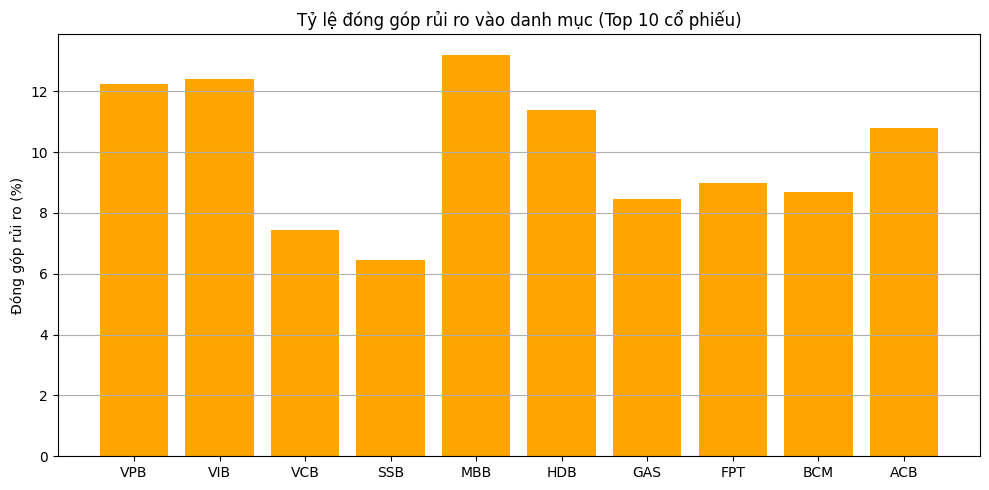

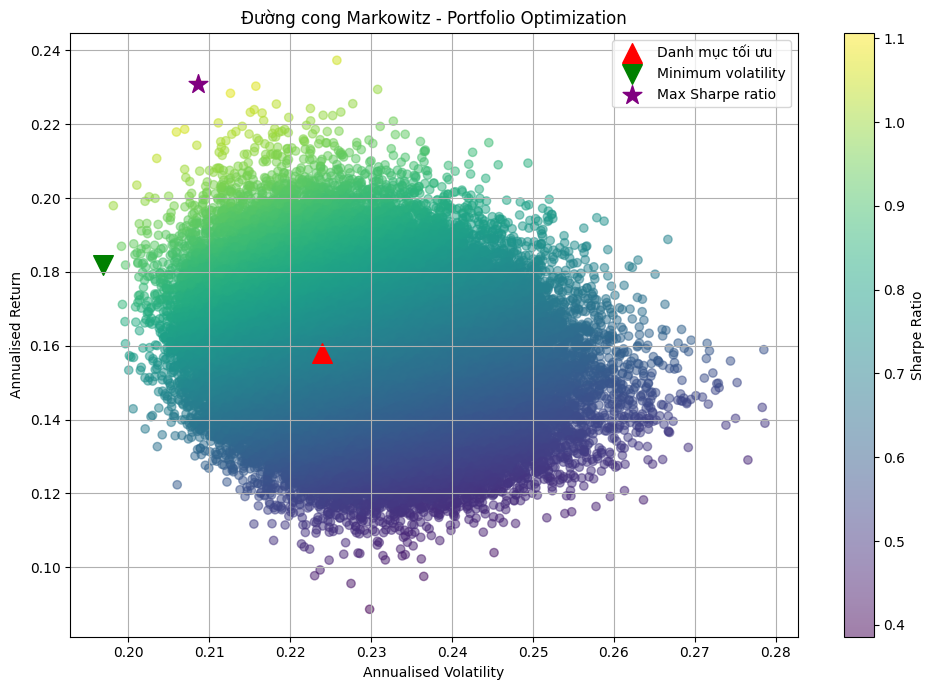

In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
def calculate_annualized_returns(df: pd.DataFrame, annualize: bool = True) -> pd.Series:
    """
    Tính tỷ suất sinh lời log và annualized return cho từng mã cổ phiếu.
    """
    required_cols = ['id', 'date', 'close']
    if not all(col in df.columns for col in required_cols):
        raise KeyError(f"Thiếu cột bắt buộc trong DataFrame: {required_cols}")
    df = df.sort_values(['id', 'date']).copy()
    df['log_return'] = df.groupby('id')['close'].apply(lambda x: np.log(x / x.shift(1))).reset_index(level=0, drop=True)
    mean_returns = df.groupby('id')['log_return'].mean()
    return mean_returns * 252 if annualize else mean_returns
def calculate_cov_matrix(df: pd.DataFrame, annualize: bool = True) -> pd.DataFrame:
    """
    Tính ma trận hiệp phương sai dựa trên log return.
    """
    pivot = df.pivot(index='date', columns='id', values='log_return')
    cov_matrix = pivot.cov()
    return cov_matrix * 252 if annualize else cov_matrix
def optimize_markowitz(mean_returns: pd.Series,
                       cov_matrix: pd.DataFrame,
                       top_n: int = 10,
                       method: str = 'min_variance',
                       lambda_l2: float = 0.0,
                       max_weight: float = 1.0) -> tuple:
    """
    Hàm tối ưu hóa danh mục theo Mean-Variance hoặc Sharpe.
    """
    tickers = mean_returns.index.tolist()
    num_assets = len(tickers)
    def objective(weights):
        variance = weights.T @ cov_matrix.values @ weights
        if method == 'sharpe':
            expected_return = weights.T @ mean_returns.values
            sharpe = expected_return / (np.sqrt(variance) + 1e-6)
            return -sharpe
        else:
            return variance + lambda_l2 * np.sum(weights**2)
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]
    bounds = [(0, max_weight)] * num_assets
    init_guess = np.array([1.0 / num_assets] * num_assets)
    result = minimize(objective, init_guess, method='SLSQP',
                      bounds=bounds, constraints=constraints)
    if not result.success:
        raise ValueError("Tối ưu hóa Markowitz thất bại.")
    weights = result.x
    top_indices = np.argsort(weights)[::-1][:top_n]
    selected_ids = [tickers[i] for i in top_indices]
    selected_weights = [weights[i] for i in top_indices]
    return selected_ids, selected_weights
def markowitz_pipeline_with_auto_retry(df: pd.DataFrame,
                                       top_n: int = 10,
                                       lambda_l2: float = 0.0,
                                       method: str = 'sharpe',
                                       max_weight_list: list = [0.1, 0.2, 0.25, 0.3, 0.5, 0.7, 1.0],
                                       annualize: bool = True) -> tuple:
    """
    Tự động thử nhiều max_weight để tránh lỗi tối ưu hóa thất bại.
    """
    # Chuẩn hóa tên cột
    df.columns = df.columns.str.lower()
    # Kiểm tra tồn tại cột
    if not {'id', 'date', 'close'}.issubset(df.columns):
        raise KeyError("DataFrame phải chứa các cột: 'id', 'date', 'close'.")
    print("Tính toán mean return và covariance matrix...")
    df = df.sort_values(['id', 'date']).copy()
    # Drop duplicate entries based on 'date' and 'id'
    df = df.drop_duplicates(subset=['date', 'id']).copy()
    df['log_return'] = df.groupby('id')['close'].apply(lambda x: np.log(x / x.shift(1))).reset_index(level=0, drop=True)
    mean_returns = calculate_annualized_returns(df, annualize)
    cov_matrix = calculate_cov_matrix(df, annualize)
    for max_weight in max_weight_list:
        print(f"Thử tối ưu với max_weight = {int(max_weight * 100)}%...")
        try:
            selected_ids, selected_weights = optimize_markowitz(
                mean_returns=mean_returns,
                cov_matrix=cov_matrix,
                top_n=top_n,
                method=method,
                lambda_l2=lambda_l2,
                max_weight=max_weight
            )
            print("Tối ưu thành công với max_weight =", max_weight)
            for t, w in zip(selected_ids, selected_weights):
                print(f" - {t}: {w:.2%}")
            return selected_ids, selected_weights
        except ValueError as e:
            print(f"Tối ưu thất bại với max_weight = {int(max_weight * 100)}%: {e}")

    raise ValueError("Tối ưu thất bại với mọi giá trị max_weight thử nghiệm.")
# Cách gọi:
# selected_ids, selected_weights = markowitz_pipeline_with_auto_retry(df, top_n=10)
# Giả sử df là dữ liệu đã xử lý gồm các cột: ['date', 'id', 'open', 'high', 'low', 'close', 'volume']
selected_ids, selected_weights = markowitz_pipeline_with_auto_retry(
    df=df,
    top_n=10,
    method='sharpe',
    lambda_l2=0.001,
    max_weight_list=[0.1, 0.2, 0.25, 0.3, 0.5, 1.0],  # Thử nhiều giới hạn trọng số
    annualize=True
)
# Lọc lại dữ liệu để đưa vào PPO
df_selected = df[df['id'].isin(selected_ids)].copy()
# ============================ PHẦN TÍNH TOÁN ============================
# Bước 1: Tính lợi suất kỳ vọng (log return trung bình hằng năm)
def calculate_annualized_returns(df: pd.DataFrame, annualize: bool = True) -> pd.Series:
    df = df.sort_values(['id', 'date']).copy()
    df['log_return'] = df.groupby('id')['close'].transform(lambda x: np.log(x / x.shift(1)))
    mean_returns = df.groupby('id')['log_return'].mean()
    return mean_returns * 252 if annualize else mean_returns
# Bước 2: Tính ma trận hiệp phương sai (covariance matrix) giữa các cổ phiếu
def calculate_cov_matrix(df: pd.DataFrame, annualize: bool = True) -> pd.DataFrame:
    df = df.drop_duplicates(subset=['date', 'id']).copy()
    log_ret_matrix = df.pivot(index='date', columns='id', values='log_return')
    cov_matrix = log_ret_matrix.cov()
    return cov_matrix * 252 if annualize else cov_matrix
# Bước 3: Tối ưu danh mục Markowitz (tối thiểu hóa phương sai hoặc tối đa Sharpe)
def optimize_markowitz(mean_returns: pd.Series, cov_matrix: pd.DataFrame,
                       top_n: int = 10, method: str = 'sharpe',
                       lambda_l2: float = 0.0, max_weight: float = 1.0):
    tickers = mean_returns.index.tolist()
    num_assets = len(tickers)
    # Hàm mục tiêu để tối ưu
    def objective(weights):
        variance = weights.T @ cov_matrix.values @ weights
        if method == 'sharpe':
            expected_return = weights.T @ mean_returns.values
            sharpe = expected_return / (np.sqrt(variance) + 1e-6)
            return -sharpe  # tối đa Sharpe ratio
        return variance + lambda_l2 * np.sum(weights ** 2)  # tối thiểu variance + regularization
    constraints = [{'type': 'eq', 'fun': lambda w: np.sum(w) - 1}]  # Tổng trọng số bằng 1
    bounds = [(0, max_weight)] * num_assets  # Ràng buộc trọng số
    init_guess = np.array([1.0 / num_assets] * num_assets)
    # Thực hiện tối ưu
    result = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    if not result.success:
        raise ValueError("Tối ưu hóa Markowitz thất bại.")
    weights = result.x
    top_indices = np.argsort(weights)[::-1][:top_n]
    selected_ids = [tickers[i] for i in top_indices]
    selected_weights = [weights[i] for i in top_indices]
    return selected_ids, selected_weights, weights
# ============================ PHẦN VẼ BIỂU ĐỒ ============================
# Biểu đồ 1: Tỷ lệ đóng góp rủi ro của từng cổ phiếu
def plot_risk_contributions(selected_ids, selected_weights, cov_matrix, mean_returns):
    tickers = mean_returns.index.tolist()
    weights_vec = np.array([selected_weights[selected_ids.index(t)] if t in selected_ids else 0.0 for t in tickers])
    port_volatility = np.sqrt(weights_vec @ cov_matrix.values @ weights_vec)
    total_risk = cov_matrix.values @ weights_vec
    risk_contrib = weights_vec * total_risk
    risk_contrib_pct = risk_contrib / (port_volatility**2 + 1e-8)
    top_risks = [risk_contrib_pct[tickers.index(t)] for t in selected_ids]
    plt.figure(figsize=(10, 5))
    plt.bar(selected_ids, np.array(top_risks) * 100, color='orange')
    plt.title("Tỷ lệ đóng góp rủi ro vào danh mục (Top 10 cổ phiếu)")
    plt.ylabel("Đóng góp rủi ro (%)")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()
# Biểu đồ 2: Đường cong Markowitz (Efficient Frontier)
def plot_efficient_frontier(mean_returns, cov_matrix, selected_ids, selected_weights):
    num_portfolios = 100_000
    results = np.zeros((3, num_portfolios))
    tickers = mean_returns.index.tolist()
    for i in range(num_portfolios):
        weights = np.random.random(len(tickers))
        weights /= np.sum(weights)
        ret = np.dot(weights, mean_returns)
        vol = np.sqrt(weights @ cov_matrix.values @ weights)
        sharpe = ret / (vol + 1e-6)
        results[0, i] = vol
        results[1, i] = ret
        results[2, i] = sharpe
    max_sharpe_idx = np.argmax(results[2])
    min_vol_idx = np.argmin(results[0])
    plt.figure(figsize=(10, 7))
    plt.scatter(results[0, :], results[1, :], c=results[2, :], cmap='viridis', alpha=0.5)
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Annualised Volatility')
    plt.ylabel('Annualised Return')
    plt.title('Đường cong Markowitz - Portfolio Optimization')
    # Vẽ điểm danh mục đã tối ưu
    w_opt = np.array([selected_weights[selected_ids.index(t)] if t in selected_ids else 0.0 for t in tickers])
    ret_opt = np.dot(w_opt, mean_returns)
    vol_opt = np.sqrt(w_opt @ cov_matrix.values @ w_opt)
    plt.scatter(vol_opt, ret_opt, marker='^', color='red', s=200, label='Danh mục tối ưu')
    # Vẽ điểm danh mục min volatility và max Sharpe từ random portfolio
    plt.scatter(results[0, min_vol_idx], results[1, min_vol_idx], marker='v', color='green', s=200, label='Minimum volatility')
    plt.scatter(results[0, max_sharpe_idx], results[1, max_sharpe_idx], marker='*', color='purple', s=200, label='Max Sharpe ratio')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
# ============================ CHẠY CHÍNH ============================
# Bước 1: Tiền xử lý log return
df = df.sort_values(['id', 'date']).drop_duplicates(subset=['date', 'id'])
df['log_return'] = df.groupby('id')['close'].transform(lambda x: np.log(x / x.shift(1)))
# Bước 2: Tính lợi suất và hiệp phương sai
mean_returns = calculate_annualized_returns(df)
cov_matrix = calculate_cov_matrix(df)
# Bước 3: Tối ưu hóa danh mục theo Markowitz
selected_ids, selected_weights, full_weights = optimize_markowitz(
    mean_returns=mean_returns,
    cov_matrix=cov_matrix,
    top_n=10,                # Chọn 10 cổ phiếu có trọng số cao nhất
    method='sharpe',   # Hoặc 'sharpe'/ min_variance
    lambda_l2=0.001,
    max_weight=0.1           # Giới hạn mỗi cổ phiếu tối đa 10%
)
# Bước 4: Vẽ các biểu đồ đánh giá danh mục
plot_risk_contributions(selected_ids, selected_weights, cov_matrix, mean_returns)
plot_efficient_frontier(mean_returns, cov_matrix, selected_ids, selected_weights)


In [11]:
import numpy as np
# Base class cho các chiến lược
class TradingStrategy:
    def generate_signal(self, df, step, tickers):
        raise NotImplementedError("Bạn cần override hàm này trong subclass.")
# Momentum Strategy (Chiến lược nền duy nhất)
class MomentumStrategy(TradingStrategy):
    def __init__(self, short_window=5, long_window=20):
        self.short = short_window
        self.long = long_window
    def generate_signal(self, df, step, tickers):
        signals = []
        for ticker in tickers:
            df_t = df[df['id'] == ticker].iloc[:step+1].copy()
            if len(df_t) < self.long:
                signals.append(0)
                continue
            sma_short = df_t['close'].rolling(self.short).mean().iloc[-1]
            sma_long = df_t['close'].rolling(self.long).mean().iloc[-1]
            signals.append(1 if sma_short > sma_long else -1)
        return np.array(signals)

# **BƯỚC 4:** MÔI TRƯỜNG MÔI TRƯỜNG GIAO DỊCH

In [12]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize
class VN30TradingEnv(gym.Env):
    metadata = {"render_modes": ["human"], "render_fps": 1}

    def __init__(
        self,
        df: pd.DataFrame,
        tickers: List[str],
        strategy_dict: Dict[str, object],
        window_size: int = 10,
        initial_cash: float = 100_000_000.0,
        transaction_cost: float = 0.001,
        max_leverage: float = 1.2,
        risk_penalty: float = 0.1,
        stability_reward: float = 0.1,
        use_markowitz: bool = True
    ):
        super().__init__()
        self.df = df.copy().reset_index(drop=True)
        self.df["date"] = pd.to_datetime(self.df["date"])
        self.tickers = tickers
        self.num_assets = len(tickers)
        self.feature_cols = [col for col in df.columns if col not in ["date", "id", "sector", "source"]]
        self.num_features = len(self.feature_cols)
        self.window_size = window_size
        self.initial_cash = initial_cash
        self.transaction_cost = transaction_cost
        self.max_leverage = max_leverage
        self.risk_penalty = risk_penalty
        self.stability_reward = stability_reward
        self.use_markowitz = use_markowitz

        self.asset_data = {ticker: df[df["id"] == ticker].reset_index(drop=True) for ticker in tickers}
        self.dates = sorted(df["date"].unique())
        self.max_steps = min(len(data) for data in self.asset_data.values()) -1
        if self.max_steps < window_size + 1:
            raise ValueError("Not enough data for the given window size.")

        self.strategy_dict = strategy_dict
        self.strategy_names = list(strategy_dict.keys())
        self.num_strategies = len(strategy_dict)

        self.action_space = spaces.Box(low=0.0, high=1.0, shape=(self.num_assets,), dtype=np.float32)
        obs_dim = (self.window_size * self.num_assets * self.num_features + self.num_assets * self.num_strategies + self.num_assets)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        self._init_state()

    def _init_state(self):
        self.current_step = self.window_size
        self.cash = self.initial_cash
        self.asset_balance = np.zeros(self.num_assets, dtype=np.float32)
        self.portfolio_value = self.initial_cash
        self.navs = [self.initial_cash]
        self.strategy_history = []
        self.history = []
        self.weights = np.zeros(self.num_assets, dtype=np.float32)
        self.markowitz_weights = np.ones(self.num_assets) / self.num_assets

        self.trades_log = []
        self.last_nav = self.initial_cash
        self.total_orders = 0
        self.total_fees = 0.0
        self.max_gross_exposure = 0.0
        self.max_drawdown_duration = 0
        self.position_coverage_log = []

    def reset(self, seed: Optional[int] = None, options: Optional[dict] = None) -> Tuple[np.ndarray, dict]:
        super().reset(seed=seed)
        self._init_state()
        obs = self._get_observation()
        info = {"portfolio_value": self.portfolio_value, "current_date": self.dates[self.current_step - 1]}
        return obs, info

    def step(self, action: np.ndarray) -> Tuple[np.ndarray, float, bool, bool, dict]:
        weights = np.asarray(action).flatten()
        weights = weights / (np.sum(np.abs(weights)) + 1e-8)

        terminated = self.current_step >= self.max_steps

        prev_nav = self.get_portfolio_value()

        if self.use_markowitz:
            self._apply_markowitz(weights)
        else:
            self.weights = weights

        prices = self._get_prices(self.current_step)
        self._update_portfolio(self.weights, prices)

        new_nav = self.get_portfolio_value()
        self.navs.append(new_nav)

        nav_change = (new_nav - prev_nav) / (prev_nav + 1e-8)
        returns = np.diff(self.navs) / self.navs[:-1]

        rolling_sharpe = np.mean(returns[-30:]) / (np.std(returns[-30:]) + 1e-8) if len(returns) >= 30 else 0.0
        neg_returns = [r for r in returns[-30:] if r < 0]
        downside_std = np.std(neg_returns) if neg_returns else 1e-6
        rolling_sortino = np.mean(returns[-30:]) / downside_std if downside_std > 0 else 0.0

        benchmark_change = 0.0
        if self.strategy_names:
            base_strategy = self.strategy_dict[self.strategy_names[0]]
            if self.current_step < self.max_steps:
                benchmark_signals = base_strategy.generate_signal(self.df, self.current_step, self.tickers)
                benchmark_weights = benchmark_signals / (np.sum(np.abs(benchmark_signals)) + 1e-8)
                prev_prices = self._get_prices(self.current_step - 1)
                benchmark_return = np.sum(benchmark_weights * (prices - prev_prices) / (prev_prices + 1e-8))
                benchmark_change = benchmark_return

        excess_return = nav_change - benchmark_change
        vol_penalty = np.std(returns[-10:]) if len(returns) >= 10 else 0.0
        drawdown = abs(self.get_max_drawdown())
        stability_bonus = 1.0 if nav_change > 0 else 0.0

        reward = (
            0.6 * nav_change
            - 0.3 * vol_penalty
            + 0.5 * rolling_sharpe
            + 0.3 * rolling_sortino
            - 0.2 * drawdown
            + 0.05 * stability_bonus
            + 0.2 * excess_return
        )

        self.history.append(nav_change)
        self.current_step += 1

        self.total_orders += np.count_nonzero(self.weights)
        self.total_fees += np.sum(np.abs(self.weights)) * self.transaction_cost
        self.trades_log.append({"step": self.current_step, "nav": new_nav, "reward": reward})
        self.position_coverage_log.append(np.count_nonzero(self.weights) / self.num_assets)
        self.max_gross_exposure = max(self.max_gross_exposure, np.sum(np.abs(self.weights)))

        obs = self._get_observation()

        info = {
            "portfolio_value": new_nav,
            "reward": reward,
            "sharpe": self.get_sharpe_ratio(),
            "max_drawdown": self.get_max_drawdown(),
            "current_date": self.dates[min(self.current_step - 1, len(self.dates) - 1)]

        }

        return obs, reward, terminated, False, info


    def _get_observation(self) -> np.ndarray:
        obs_list = []
        for ticker in self.tickers:
            data = self.asset_data[ticker]
            start_idx = max(0, self.current_step - self.window_size)
            end_idx = self.current_step
            obs = data.iloc[start_idx:end_idx][self.feature_cols].values
            if len(obs) < self.window_size:
                padding = np.zeros((self.window_size - len(obs), self.num_features))
                obs = np.concatenate([padding, obs], axis=0)

            obs_list.append(obs)
        tech_obs = np.concatenate(obs_list, axis=0).flatten()

        strat_signals = []
        for name in self.strategy_names:
            if self.current_step > self.window_size:
                 signals = self.strategy_dict[name].generate_signal(self.df, self.current_step -1, self.tickers) # Pass current step -1
            else:
                 signals = np.zeros(self.num_assets)
            strat_signals.append(signals)
        strat_obs = np.concatenate(strat_signals, axis=0)

        return np.concatenate([tech_obs, strat_obs, self.markowitz_weights]).astype(np.float32)

    def _get_prices(self, idx: int) -> np.ndarray:
        if idx >= len(self.dates):
             idx = len(self.dates) - 1
        date = self.dates[idx]
        prices = []
        for ticker in self.tickers:
            price_data = self.asset_data[ticker][self.asset_data[ticker]['date'] == date]['close']
            if not price_data.empty:
                prices.append(price_data.iloc[0])
            else:
                last_known_price = self.asset_data[ticker].iloc[min(idx, len(self.asset_data[ticker]) - 1)]['close']
                prices.append(last_known_price)
        return np.array(prices, dtype=np.float32)

    def _update_portfolio(self, weights: np.ndarray, prices: np.ndarray):
        alloc = weights / (np.sum(np.abs(weights)) + 1e-8)
        total_value = self.get_portfolio_value()
        target_values = alloc * total_value
        current_values = self.asset_balance * prices
        delta_values = target_values - current_values
        trade_shares = delta_values / (prices + 1e-8)
        transaction_costs = np.sum(np.abs(trade_shares * prices)) * self.transaction_cost

        total_trade_cost = np.sum(trade_shares * prices) + transaction_costs
        if total_trade_cost > self.cash:
            scale = self.cash / (total_trade_cost + 1e-8)
            trade_shares *= scale
            transaction_costs *= scale

        self.asset_balance += trade_shares
        self.cash -= np.sum(trade_shares * prices) + transaction_costs

    def get_portfolio_value(self) -> float:
        price_step = min(self.current_step - 1, len(self.dates) - 1)
        if price_step < self.window_size -1:
             return float(self.initial_cash)
        prices = self._get_prices(price_step)
        return float(self.cash + np.sum(self.asset_balance * prices))

    def _apply_markowitz(self, raw_weights: np.ndarray):
        raw_weights = raw_weights / (np.sum(raw_weights) + 1e-8)
        returns_list, valid_assets = [], []
        if self.current_step < self.window_size + 1:
             self.markowitz_weights = np.ones(self.num_assets) / self.num_assets
             self.weights = self.markowitz_weights
             return

        for idx, ticker in enumerate(self.tickers):
            start_idx = max(0, self.current_step - self.window_size)
            end_idx = self.current_step
            prices = self.asset_data[ticker].iloc[start_idx:end_idx]["close"].values

            if len(prices) >= self.window_size:
                ret = np.diff(prices) / (prices[:-1] + 1e-8)
                if not np.any(np.isnan(ret)) and not np.all(ret == 0):
                    returns_list.append(ret)
                    valid_assets.append(idx)

        if len(valid_assets) < 2:
            self.markowitz_weights = np.ones(self.num_assets) / self.num_assets
            self.weights = self.markowitz_weights
            return

        R = np.stack(returns_list, axis=-1)
        mu = np.mean(R, axis=0)
        Sigma = np.cov(R, rowvar=False)

        if not np.all(np.isfinite(Sigma)) or np.linalg.cond(Sigma) > 1e10:
             Sigma = Sigma + np.identity(len(valid_assets)) * 1e-6
        bounds = [(0, 1)] * len(valid_assets)
        constraints = {"type": "eq", "fun": lambda w: np.sum(w) - 1}
        init_guess = raw_weights[valid_assets]
        result = minimize(lambda w: float(w @ Sigma @ w), init_guess, method="SLSQP", bounds=bounds, constraints=constraints)

        markowitz_weights = result.x if result.success else init_guess
        self.markowitz_weights = np.zeros(self.num_assets)
        for i, idx in enumerate(valid_assets):
            self.markowitz_weights[idx] = markowitz_weights[i]

        self.weights = self.markowitz_weights / (np.sum(self.markowitz_weights) + 1e-8)

    def get_sharpe_ratio(self) -> float:
        if len(self.navs) < 2:
            return 0.0
        returns = np.diff(self.navs) / self.navs[:-1]
        return np.mean(returns) / (np.std(returns) + 1e-8) * np.sqrt(252)

    def get_max_drawdown(self) -> float:
        navs = np.array(self.navs)
        peak = np.maximum.accumulate(navs)
        drawdowns = (navs - peak) / (peak + 1e-8)
        return np.min(drawdowns) if len(drawdowns) > 0 else 0.0

    def render(self):
        print(f"Step {self.current_step}/{self.max_steps} | NAV: {self.get_portfolio_value():,.2f}")

    def close(self):
        pass

# **BƯỚC 5:** HUẤN LUYỆN PPO

In [13]:
import os
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces, Wrapper
from typing import List, Dict, Optional, Tuple
from scipy.optimize import minimize
import torch
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.callbacks import BaseCallback, CheckpointCallback, EvalCallback, CallbackList
from stable_baselines3.common.monitor import Monitor
# === Risk Management Wrapper ===
class RiskManagementWrapper(Wrapper):
    def __init__(self, env, reward_scaling: float = 1.0, max_drawdown_threshold: float = -0.25):
        super().__init__(env)
        self.reward_scaling = reward_scaling
        self.max_drawdown_threshold = max_drawdown_threshold

    def step(self, action):
        obs, reward, terminated, truncated, info = self.env.step(action)
        reward *= self.reward_scaling
        if info.get("max_drawdown", 0) < self.max_drawdown_threshold:
            terminated = True
            info["early_stop"] = "drawdown_limit_exceeded"
        return obs, reward, terminated, truncated, info
# === TensorBoard Entropy Logging ===
class TensorboardEntropyCallback(BaseCallback):
    def __init__(self, verbose=0):
        super().__init__(verbose)

    def _on_step(self) -> bool:
        if self.logger:
            entropy = self.model.ent_coef
            if isinstance(entropy, torch.Tensor):
                entropy = entropy.item()
            self.logger.record("train/entropy", entropy)
        return True
# === Create Vec Environment ===
def create_vec_env(env_fn):
    vec_env = DummyVecEnv([env_fn])
    vec_env = VecNormalize(VecMonitor(vec_env), norm_obs=True, norm_reward=False, clip_obs=10.0)
    return vec_env
# === Train PPO Agent ===
def train_ppo_agent(env_fn, eval_env_fn, save_dir="./checkpoints", total_timesteps=10_000):
    os.makedirs(save_dir, exist_ok=True)

    vec_env = create_vec_env(env_fn)
    vec_eval_env = create_vec_env(eval_env_fn)
    vec_eval_env.training = False

    checkpoint_callback = CheckpointCallback(
        save_freq=10_000,
        save_path=save_dir,
        name_prefix="ppo_vn30"
    )

    eval_callback = EvalCallback(
        vec_eval_env,
        best_model_save_path=save_dir,
        log_path=save_dir,
        eval_freq=10_000,
        deterministic=True,
        render=False
    )

    entropy_callback = TensorboardEntropyCallback()
    callback = CallbackList([checkpoint_callback, eval_callback, entropy_callback])

    model = PPO(
        "MlpPolicy",
        vec_env,
        verbose=1,
        tensorboard_log=os.path.join(save_dir, "tensorboard"),
        n_steps=2048,
        batch_size=64,
        gae_lambda=0.95,
        gamma=0.99,
        ent_coef=0.005,
        learning_rate=3e-4,
        clip_range=0.2,
        n_epochs=10,
        max_grad_norm=0.5
    )

    model.learn(total_timesteps=total_timesteps, callback=callback)
    model.save(os.path.join(save_dir, "ppo_final_model"))
    print("Training complete. Final model saved.")
    return model


# **BƯỚC 6:** ĐÁNH GIÁ MÔ HÌNH PPO

In [14]:
import numpy as np
import pandas as pd
import itertools
import torch
import matplotlib.pyplot as plt

def evaluate_performance(env, model=None) -> pd.DataFrame:
    navs = np.array(env.navs)
    trades = pd.DataFrame(env.trades_log)

    total_return = (navs[-1] - navs[0]) / navs[0]

    running_max = np.maximum.accumulate(navs)
    drawdowns = navs - running_max
    max_dd = np.min(drawdowns) / (running_max.max() + 1e-8)
    dd_duration = max((len(list(g)) for k, g in itertools.groupby(drawdowns < 0) if k), default=0)

    trade_returns = trades["nav"].pct_change().dropna() if "nav" in trades else pd.Series()
    winning_trades = trade_returns[trade_returns > 0]
    losing_trades = trade_returns[trade_returns < 0]

    sharpe = (trade_returns.mean() / (trade_returns.std() + 1e-8)) * np.sqrt(252) if not trade_returns.empty else np.nan
    sortino = (trade_returns.mean() / (trade_returns[trade_returns < 0].std() + 1e-8)) * np.sqrt(252) if not trade_returns.empty else np.nan
    profit_factor = winning_trades.sum() / abs(losing_trades.sum() + 1e-8) if not trade_returns.empty else "N/A"
    expectancy = trade_returns.mean() if not trade_returns.empty else np.nan

    entropy_value = getattr(model, "ent_coef", None)
    if isinstance(entropy_value, torch.Tensor):
        entropy_value = entropy_value.item()
    entropy_display = round(entropy_value, 6) if entropy_value is not None else "Không có ent_coef"
    summary = {
        "Start NAV": f"{navs[0]:,.0f}",
        "End NAV": f"{navs[-1]:,.0f}",
        "Total Return": f"{total_return:.2%}",
        "Max Drawdown": f"{max_dd:.2%}",
        "Max Drawdown Duration": dd_duration,
        "Total Orders": getattr(env, "total_orders", "N/A"),
        "Total Trades": len(trade_returns),
        "Total Fees Paid": f"{getattr(env, 'total_fees', 0):,.0f} đ",
        "Win Rate": f"{(len(winning_trades) / len(trade_returns)):.2%}" if len(trade_returns) > 0 else "N/A",
        "Best Trade": f"{trade_returns.max():.2%}" if not trade_returns.empty else "N/A",
        "Worst Trade": f"{trade_returns.min():.2%}" if not trade_returns.empty else "N/A",
        "Avg Winning Trade": f"{winning_trades.mean():.2%}" if not winning_trades.empty else "N/A",
        "Avg Losing Trade": f"{losing_trades.mean():.2%}" if not losing_trades.empty else "N/A",
        "Profit Factor": round(profit_factor, 3) if not isinstance(profit_factor, str) else profit_factor,
        "Expectancy": round(expectancy, 5) if not np.isnan(expectancy) else "N/A",
        "Sharpe Ratio": round(sharpe, 3) if not np.isnan(sharpe) else "N/A",
        "Sortino Ratio": round(sortino, 3) if not np.isnan(sortino) else "N/A",
        "Max Gross Exposure": round(getattr(env, 'max_gross_exposure', 0), 3),
        "Total Steps": len(trades),
        "Mean Episode Reward": round(trades["reward"].mean(), 6) if "reward" in trades and not trades["reward"].empty else "N/A",
        "Entropy": entropy_display
    }

    return pd.DataFrame([summary]).T.rename(columns={0: "Value"})
def plot_drawdown(env):
    navs = np.array(env.navs)
    peak = np.maximum.accumulate(navs)
    drawdown = (navs - peak) / (peak + 1e-8)
    dates = env.dates[env.window_size:env.window_size + len(drawdown)]

    plt.figure(figsize=(12, 4))
    plt.plot(dates, drawdown, color='red')
    plt.title("Maximum Drawdown Over Time")
    plt.xlabel("Date")
    plt.ylabel("Drawdown (%)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
def plot_rolling_sharpe(env, window: int = 20):
    navs = np.array(env.navs[env.window_size:])
    returns = pd.Series(np.diff(navs) / navs[:-1])
    rolling_mean = returns.rolling(window).mean()
    rolling_std = returns.rolling(window).std()
    rolling_sharpe = (rolling_mean / (rolling_std + 1e-8)) * np.sqrt(252)

    valid_dates = env.dates[env.window_size + window - 1:env.current_step]
    min_len = min(len(valid_dates), len(rolling_sharpe))
    valid_dates = valid_dates[:min_len]
    rolling_sharpe = rolling_sharpe[:min_len]

    plt.figure(figsize=(12, 4))
    plt.plot(valid_dates, rolling_sharpe, label=f"{window}-step Rolling Sharpe")
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title("Rolling Sharpe Ratio")
    plt.xlabel("Date")
    plt.ylabel("Sharpe Ratio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Using cpu device
Logging to ./checkpoints/tensorboard/PPO_1
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 26.8     |
|    ep_rew_mean     | 1.66e+04 |
| time/              |          |
|    fps             | 14       |
|    iterations      | 1        |
|    time_elapsed    | 144      |
|    total_timesteps | 2048     |
| train/             |          |
|    entropy         | 0.005    |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27          |
|    ep_rew_mean          | 1.66e+04    |
| time/                   |             |
|    fps                  | 14          |
|    iterations           | 2           |
|    time_elapsed         | 289         |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.012597682 |
|    clip_fraction        | 0.127       |
|    clip_range           | 

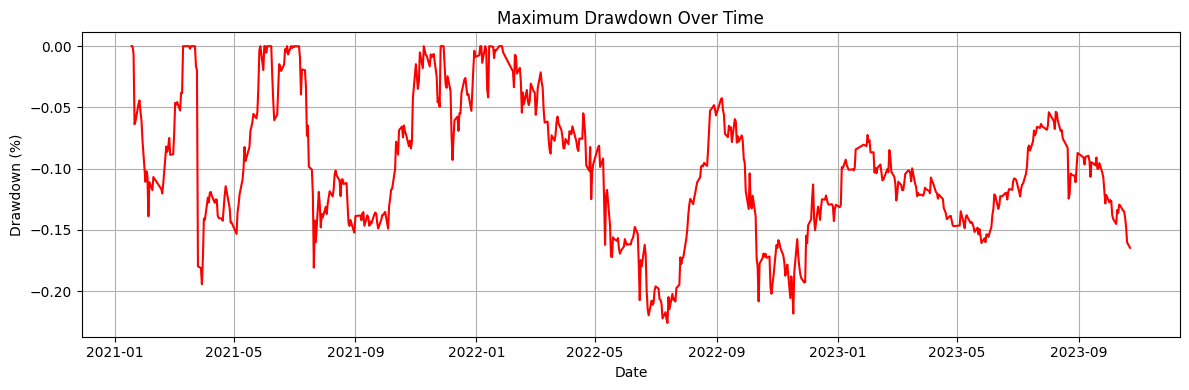

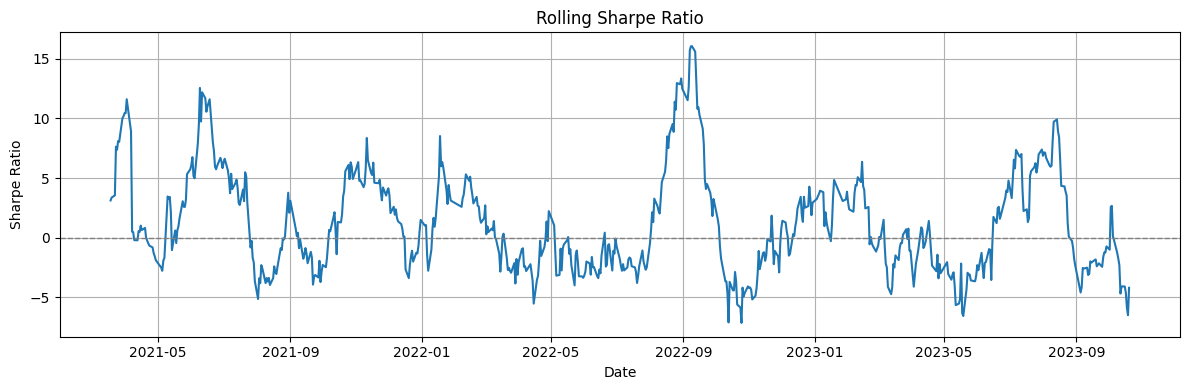

In [15]:
# === BƯỚC 1: TẢI DỮ LIỆU ===
df = pd.read_csv("/content/vn30_30stocks_train_2021_2023_con10cp.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values(["date", "id"])
# === BƯỚC 2: CẤU HÌNH CHIẾN LƯỢC & CỔ PHIẾU ===
strategy_dict = {
    "Momentum": MomentumStrategy()
}
tickers = sorted(df["id"].unique())
tickers = [t for t in tickers if t != "VN30_INDEX"]
# === BƯỚC 3: HÀM TẠO ENVIRONMENT ===
def env_fn():
    env = VN30TradingEnv(
        df=df,
        tickers=tickers,
        strategy_dict=strategy_dict,
        window_size=10,
        initial_cash=100_000_000,
        transaction_cost=0.001,
        max_leverage=1.2,
        use_markowitz=True,
    )
    return RiskManagementWrapper(env, reward_scaling=10.0, max_drawdown_threshold=-0.10)
def eval_env_fn():
    return VN30TradingEnv(
        df=df,
        tickers=tickers,
        strategy_dict=strategy_dict,
        window_size=10,
        initial_cash=100_000_000,
        transaction_cost=0.001,
        max_leverage=1.2,
        use_markowitz=True,
    )
# === BƯỚC 4: HUẤN LUYỆN PPO ===
model = train_ppo_agent(env_fn, eval_env_fn, total_timesteps=400_000, save_dir="./checkpoints")
# === BƯỚC 5: CHẠY MÔ HÌNH ĐỂ GHI LOG ===
eval_env = eval_env_fn()
obs, _ = eval_env.reset()
done = False
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = eval_env.step(action)
# === BƯỚC 6: ĐÁNH GIÁ & VẼ BIỂU ĐỒ ===
performance_df = evaluate_performance(eval_env, model=model)
print("PERFORMANCE REPORT:")
print(performance_df)
plot_drawdown(eval_env)
plot_rolling_sharpe(eval_env)

▶ Running strategy: Momentum
▶ Running strategy: MeanReversion
▶ Running strategy: Scalping


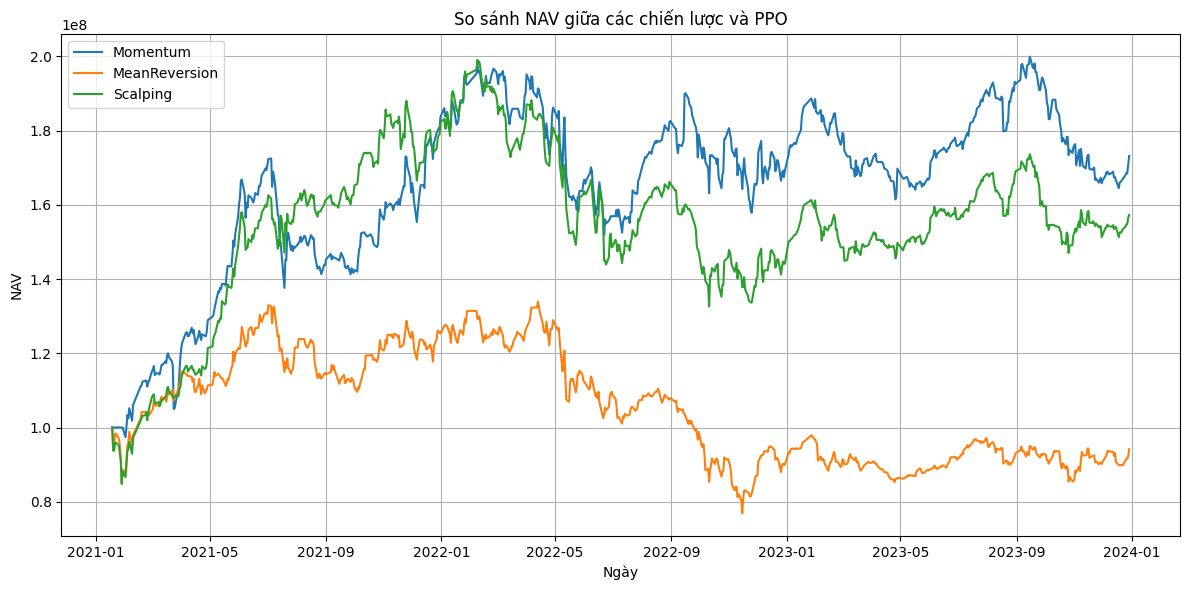

|    | Strategy      |   Total Return |    Sharpe |   Volatility |
|----|---------------|----------------|-----------|--------------|
|  0 | Momentum      |      0.731189  | 0.863913  |    0.0160617 |
|  1 | MeanReversion |     -0.0584138 | 0.0360898 |    0.0152102 |
|  2 | Scalping      |      0.57283   | 0.758778  |    0.0153175 |


In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
import torch
from tabulate import tabulate
class TradingStrategy:
    def generate_signal(self, df, step, tickers):
        raise NotImplementedError
class MomentumStrategy(TradingStrategy):
    def __init__(self, short_window=5, long_window=20):
        self.short = short_window
        self.long = long_window

    def generate_signal(self, df, step, tickers):
        signals = []
        for ticker in tickers:
            df_t = df[df['id'] == ticker].iloc[:step+1].copy()
            if len(df_t) < self.long:
                signals.append(0)
                continue
            sma_short = df_t['close'].rolling(self.short).mean().iloc[-1]
            sma_long = df_t['close'].rolling(self.long).mean().iloc[-1]
            signals.append(1 if sma_short > sma_long else -1)
        return np.array(signals)
class MeanReversionStrategy(TradingStrategy):
    def __init__(self, window=10):
        self.window = window

    def generate_signal(self, df, step, tickers):
        signals = []
        for ticker in tickers:
            prices = df[df['id'] == ticker].iloc[:step+1]['close'].values
            if len(prices) < self.window:
                signals.append(0)
            else:
                mean = prices[-self.window:].mean()
                signals.append(1 if prices[-1] < mean else -1)
        return np.array(signals)
class ScalpingStrategy(TradingStrategy):
    def __init__(self, window=3):
        self.window = window

    def generate_signal(self, df, step, tickers):
        signals = []
        for ticker in tickers:
            prices = df[df['id'] == ticker].iloc[:step+1]['close'].values
            if len(prices) < self.window + 1:
                signals.append(0)
            else:
                returns = prices[-self.window:] - prices[-self.window - 1:-1]
                signals.append(1 if returns.mean() > 0 else -1)
        return np.array(signals)
# ========== MÔ PHỎNG DANH MỤC ========== #
def simulate_portfolio_strategy(df, tickers, strategy, window_size=10, initial_cash=100_000_000):
    df = df.copy()
    cash = initial_cash
    navs = [cash]
    dates = sorted(df['date'].unique())
    for step in range(window_size, len(dates) - 1):
        signals = strategy.generate_signal(df, step, tickers)
        selected = np.where(signals > 0)[0]
        if len(selected) == 0:
            navs.append(navs[-1])
            continue

        date = dates[step]
        next_date = dates[step + 1]

        today_prices = df[(df['date'] == date) & (df['id'].isin(tickers))] \
            .drop_duplicates(subset='id', keep='last') \
            .set_index('id').reindex(tickers)['close'].values

        next_prices = df[(df['date'] == next_date) & (df['id'].isin(tickers))] \
            .drop_duplicates(subset='id', keep='last') \
            .set_index('id').reindex(tickers)['close'].values

        today_prices = np.nan_to_num(today_prices, nan=np.nanmean(today_prices))
        next_prices = np.nan_to_num(next_prices, nan=np.nanmean(next_prices))

        weights = np.zeros(len(tickers))
        weights[selected] = 1 / len(selected)
        returns = (next_prices - today_prices) / today_prices
        portfolio_return = np.dot(weights, returns)
        navs.append(navs[-1] * (1 + portfolio_return))
    return dates[window_size:window_size + len(navs)], navs

# ========== TÍNH METRICS ========== #
def compute_metrics(nav):
    nav = pd.Series(nav)
    daily_returns = nav.pct_change().dropna()
    total_return = nav.iloc[-1] / nav.iloc[0] - 1
    sharpe = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252) if daily_returns.std() > 0 else 0
    return {
        "Total Return": total_return,
        "Sharpe": sharpe,
        "Volatility": daily_returns.std(),
    }

# ========== MAIN PIPELINE ========== #
df = pd.read_csv("/content/vn30_30stocks_train_2021_2023_con10cp.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date', 'id'])
tickers = sorted(df['id'].unique())

strategies = {
    "Momentum": MomentumStrategy(),
    'MeanReversion': MeanReversionStrategy(),
    'Scalping': ScalpingStrategy()
}

strategy_navs = {}
for name, strat in strategies.items():
    print(f"▶ Running strategy: {name}")
    dates, navs = simulate_portfolio_strategy(df, tickers, strat)
    strategy_navs[name] = (dates, navs)

# ========== VẼ BIỂU ĐỒ ==========
plt.figure(figsize=(12, 6))
for name, (dates, navs) in strategy_navs.items():
    plt.plot(dates, navs, label=name)
plt.title("So sánh NAV giữa các chiến lược và PPO")
plt.xlabel("Ngày")
plt.ylabel("NAV")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ========== IN HIỆU SUẤT ==========
rows = []
for name, (_, nav) in strategy_navs.items():
    metrics = compute_metrics(nav)
    rows.append({"Strategy": name, **metrics})

df_metrics = pd.DataFrame(rows)
print(tabulate(df_metrics, headers='keys', tablefmt='github'))


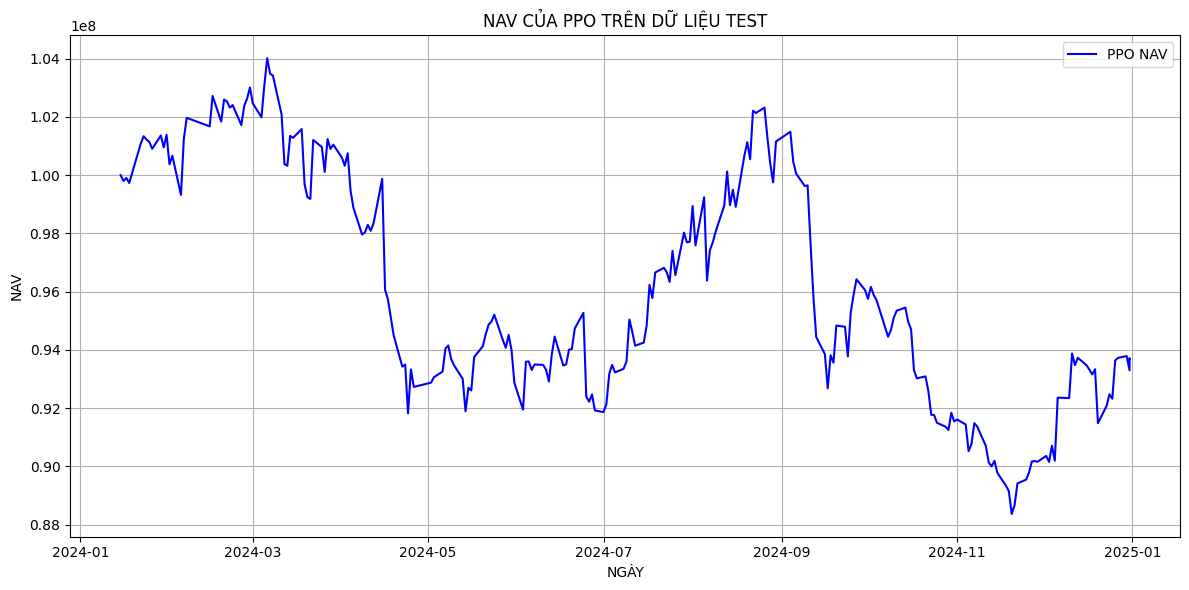

PERFORMANCE REPORT ON TEST DATA:
Start NAV:              100,000,000
End NAV:                93,700,928
Total Return:           -6.30%
Sharpe Ratio:           -0.32
Max Drawdown:           -15.04%
Total Orders:           2137
Total Fees Paid:        0 đ
Position Coverage:      49.47%
Max Gross Exposure:     1.00
Total Steps:            432


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
from stable_baselines3 import PPO
from torch.utils.tensorboard import SummaryWriter
# Đọc file test đúng
df = pd.read_csv("/content/vn30_30stocks_test_2024_con10cp.csv")
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(['date', 'id'])
# Tạo df_test từ dữ liệu test
df_test = df.copy()
# Load mô hình đã huấn luyện
model = PPO.load("/content/checkpoints/ppo_final_model.zip")
# Khởi tạo môi trường VN30TradingEnv
env = VN30TradingEnv(
    df=df_test,
    tickers=list(df_test["id"].unique()),  # lấy danh sách mã cổ phiếu
    strategy_dict=strategy_dict,           # giữ nguyên như cũ
    window_size=10,
    initial_cash=100_000_000,
    use_markowitz=True
)
# Reset môi trường
obs, _ = env.reset()
done = False
ppo_navs = [env.portfolio_value]
ppo_dates = [env.dates[env.current_step - 1]]
ppo_rewards = []
ppo_weights = []
while not done:
    current_date = env.dates[env.current_step] if env.current_step < len(env.dates) else env.dates[-1]
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, info = env.step(action)
    ppo_navs.append(info["portfolio_value"])
    ppo_dates.append(info["current_date"])
    ppo_rewards.append(reward)
    ppo_weights.append(env.weights.copy())
# Vẽ biểu đồ NAV
plt.figure(figsize=(12, 6))
plt.plot(ppo_dates, ppo_navs, label="PPO NAV", color="blue")
plt.title("NAV CỦA PPO TRÊN DỮ LIỆU TEST")
plt.xlabel("NGÀY")
plt.ylabel("NAV")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
# Đánh giá hiệu suất
final_nav = ppo_navs[-1]
total_return = (final_nav - ppo_navs[0]) / ppo_navs[0]
sharpe_ratio = env.get_sharpe_ratio() if len(ppo_navs) > 1 else 0.0
max_dd = env.get_max_drawdown()
print("PERFORMANCE REPORT ON TEST DATA:")
print(f"Start NAV:              {ppo_navs[0]:,.0f}")
print(f"End NAV:                {final_nav:,.0f}")
print(f"Total Return:           {total_return:.2%}")
print(f"Sharpe Ratio:           {sharpe_ratio:.2f}")
print(f"Max Drawdown:           {max_dd:.2%}")
print(f"Total Orders:           {env.total_orders}")
print(f"Total Fees Paid:        {env.total_fees:,.0f} đ")
print(f"Position Coverage:      {np.mean(env.position_coverage_log):.2%}")
print(f"Max Gross Exposure:     {env.max_gross_exposure:.2f}")
print(f"Total Steps:            {len(ppo_rewards)}")
# Ghi log ra TensorBoard
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir="./ppo_test_log")
writer.add_scalar("Test/End_NAV", final_nav)
writer.add_scalar("Test/Total_Return", total_return)
writer.add_scalar("Test/Sharpe_Ratio", sharpe_ratio)
writer.add_scalar("Test/Max_Drawdown", max_dd)
writer.add_scalar("Test/Total_Orders", env.total_orders)
writer.close()